In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import datetime as dt
import json
from typing import List, Optional

import pymongo
from pandas import DataFrame
from pymongo.results import InsertManyResult

In [3]:
with open('DSCC-FP-MVP-Configuration.JSON') as f:
   configuration = json.load(f)

client = pymongo.MongoClient(configuration['mongo_uri'])
db = client[configuration['database_name']]

In [4]:
def convert_dataframe_to_list(df: DataFrame) -> List[object]:
    """Converts dataframe into list and resets the dataframe index

    Args:
        df (DataFrame): Pandas DataFrame

    Returns:
        List[object]: List of dictionary
    """
    df.reset_index(inplace=True)
    return list(df.T.to_dict().values())

In [5]:
def fetch_stock_data_from_db(stock_name: str, start_date: Optional[str] = None, end_date: Optional[str] = None) -> List[object]:
    """Retrieve the stock data from MongoDb collection

    Args:
        stock_name (str): Stock Name
        start_date (Optional[str], optional): Start date to filter records. Defaults to None.
        end_date (Optional[str], optional): End date to filter records. Defaults to None.

    Returns:
        List[object]: List of dictionaries
    """
    if start_date and end_date:
        search_query = {
            "stock": stock_name,
            "Date": {
                '$gte':  dt.datetime.strptime(start_date, '%Y-%m-%d'),
                '$lt': dt.datetime.strptime(end_date, '%Y-%m-%d') + dt.timedelta(1)
            }
        }
    else:
        search_query = {
            "stock": stock_name,
        }
    records = db.stock_price.find(search_query).sort('Date', pymongo.ASCENDING)
    output = [record for record in records]
    return output

In [6]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [7]:
stockList = ['AAPL', 'SMSN.IL']

In [130]:

df_ = {}
for i in stockList:
    df_[i] = pd.DataFrame(fetch_stock_data_from_db(i))
    df_[i].set_index("Date", inplace=True)
    df_[i].index = pd.to_datetime(df_[i].index)
# df_

In [96]:
for i in stockList:
    print(i, df_[i].shape)

AAPL (1005, 8)
SMSN.IL (1012, 8)


In [97]:
df_['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2018-01-02 to 2021-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _id        1005 non-null   object 
 1   Open       1005 non-null   float64
 2   High       1005 non-null   float64
 3   Low        1005 non-null   float64
 4   Close      1005 non-null   float64
 5   Adj Close  1005 non-null   float64
 6   Volume     1005 non-null   int64  
 7   stock      1005 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 70.7+ KB


In [98]:
df_['AAPL'].index.dtype

dtype('<M8[ns]')

In [131]:
for i in stockList:
    for j in stockList:
        if i != j:
            diff_index = df_[i].index.difference(df_[j].index)
            print(diff_index)
            for idx in diff_index:
                df_[j].loc[idx] = [None for _ in range(len(df_[j].columns))]
                df_[j].sort_index(inplace=True)
                df_[j].fillna(method='ffill', inplace=True)
                df_[j].fillna(method='bfill', inplace=True)
                df_[j].index = pd.to_datetime(df_[j].index)


DatetimeIndex(['2018-04-02', '2018-05-07', '2018-08-27', '2018-12-26',
               '2019-04-22', '2019-05-06', '2019-08-26', '2019-12-26',
               '2020-04-13', '2020-05-08', '2020-08-31', '2020-12-28',
               '2021-04-05', '2021-05-03', '2021-08-30', '2021-12-27',
               '2021-12-28'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2018-01-15', '2018-02-19', '2018-07-04', '2018-09-03',
               '2018-11-22', '2018-12-05', '2019-01-21', '2019-02-18',
               '2019-07-04', '2019-09-02', '2019-11-28', '2019-12-31',
               '2020-01-20', '2020-02-17', '2020-07-03', '2020-09-07',
               '2020-11-26', '2020-12-31', '2021-01-18', '2021-02-15',
               '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [119]:
df_['AAPL'].index.difference(df_['SMSN.IL'].index)

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [120]:
dts = df_['SMSN.IL'].index.difference(df_['AAPL'].index)
dts

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [121]:
for i in stockList:
    print(i, df_[i].shape)

AAPL (1029, 8)
SMSN.IL (1029, 8)


In [125]:
df_['AAPL'].isnull().sum()

_id          0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
stock        0
dtype: int64

In [126]:
df_['SMSN.IL'].isnull().sum()

_id          0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
stock        0
dtype: int64

In [44]:
df_['AAPL'].fillna(method='ffill').fillna(method='bfill', inplace=True)

In [10]:
# df_ = {}
# df_['AAPL'] = pd.read_csv("./data/AAPL.csv", index_col="Date", parse_dates=["Date"])
# df_['SMSN.IL'] = pd.read_csv("./data/SMSN.IL.csv", index_col="Date", parse_dates=["Date"])
# df_

In [123]:
df_['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1029 entries, 2018-01-02 to 2021-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _id        1029 non-null   object 
 1   Open       1029 non-null   float64
 2   High       1029 non-null   float64
 3   Low        1029 non-null   float64
 4   Close      1029 non-null   float64
 5   Adj Close  1029 non-null   float64
 6   Volume     1029 non-null   int64  
 7   stock      1029 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 72.4+ KB


In [132]:
def split_df(dataframe, date_str, col):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d') 
    test_date_obj = date_obj + timedelta(days=1) 

    return dataframe.loc[:date_obj.date(),col], dataframe.loc[test_date_obj.date():,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split_df(df_[i], "2021-01-01", "Close")

In [135]:
type(split_df(df_[i], "2021-01-01", "Close"))

tuple

In [133]:
for i in stockList:
    print(i, df_new[i]["Train"].shape, df_new[i]["Test"].shape)

AAPL (772,) (257,)
SMSN.IL (772,) (257,)


In [21]:
df_new['AAPL']["Test"][60:].index.difference(df_new['SMSN.IL']["Test"][60:].index)

DatetimeIndex(['2021-04-05', '2021-05-03', '2021-08-30', '2021-12-27',
               '2021-12-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [17]:
df_new['AAPL']["Test"][60:].index.shape

(191,)

In [18]:
df_new['SMSN.IL']["Test"][60:].index.shape

(192,)

In [ ]:
dataframe = df_['AAPL']
dataframe.loc[:"2021-10-31", "Close"]

In [ ]:
dataframe.loc["2021-11-01":, "Close"]

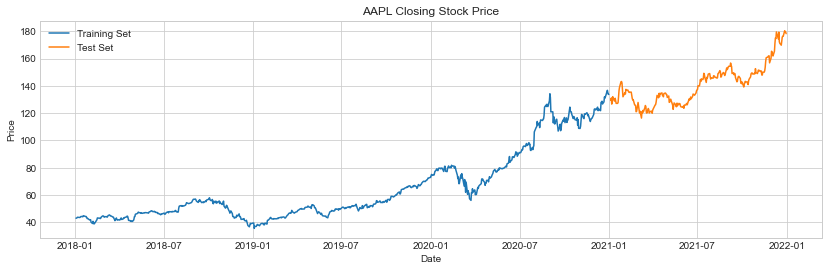

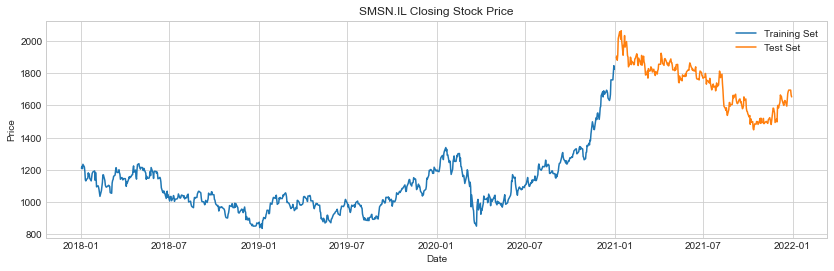

In [134]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [10]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [11]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

AAPL (398, 1)
SMSN.IL (400, 1)


AAPL (106, 1)
SMSN.IL (106, 1)


In [30]:
transform_test['AAPL'].shape

(106, 1)

In [35]:
transform_test['AAPL'][0:60, 0]

array([0.15489207, 0.19956303, 0.18960907, 0.19227964, 0.16994415,
       0.16873019, 0.15683434, 0.16314643, 0.23670792, 0.24180642,
       0.29084717, 0.26826905, 0.1752853 , 0.18353963, 0.21971358,
       0.25661586, 0.25443057, 0.22384077, 0.20393283, 0.22966755,
       0.33940265, 0.30808454, 0.32459323, 0.35226982, 0.36805057,
       0.42607433, 0.38771549, 0.36246679, 0.23865019, 0.25273132,
       0.21801397, 0.2401068 , 0.23428   , 0.16800191, 0.09225547,
       0.10415134, 0.16290378, 0.18669586, 0.18888076, 0.1512502 ,
       0.06724945, 0.08958492, 0.05729548, 0.08521473, 0.        ,
       0.04782719, 0.06943435, 0.10075246, 0.09128416, 0.08909927,
       0.05753814, 0.04297171, 0.11216304, 0.13838302, 0.17989812,
       0.23355172, 0.24569059, 0.25103171, 0.23185245, 0.23063849])

In [34]:
transform_test['AAPL'][60, 0]

0.24714754208685052

In [26]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,398):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 106):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

    print(testset[j]["X"].shape)

(46, 60, 1)
(46, 60, 1)


In [13]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
AAPL,"(338, 60, 1)","(338,)","(46, 60, 1)","(46,)"
SMSN.IL,"(338, 60, 1)","(338,)","(46, 60, 1)","(46,)"


In [19]:
X_train.shape[1]

60

In [14]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to AAPL
Epoch 1/10
2/2 [==============================] - 14s 54ms/step - loss: 0.3389
Epoch 2/10
2/2 [==============================] - 0s 53ms/step - loss: 0.1040
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 0.0349
Epoch 4/10
2/2 [==============================] - 0s 50ms/step - loss: 0.0366
Epoch 5/10
2/2 [==============================] - 0s 62ms/step - loss: 0.0294
Epoch 6/10
2/2 [==============================] - 0s 45ms/step - loss: 0.0361
Epoch 7/10
2/2 [==============================] - 0s 58ms/step - loss: 0.0518
Epoch 8/10
2/2 [==============================] - 0s 58ms/step - loss: 0.0444
Epoch 9/10
2/2 [==============================] - 0s 54ms/step - loss: 0.0347
Epoch 10/10
2/2 [==============================] - 0s 56ms/step - loss: 0.0313
Fitting to SMSN.IL
Epoch 1/10
2/2 [==============================] - 0s 56ms/step - loss: 0.0242
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 0.0302
Epoch 3/10
2/2 [===========

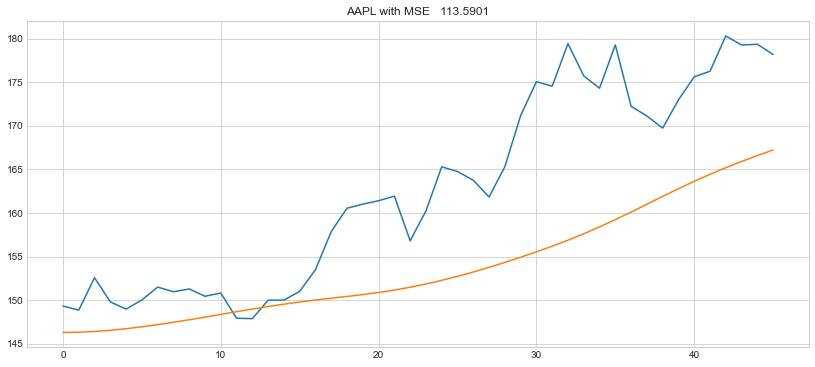

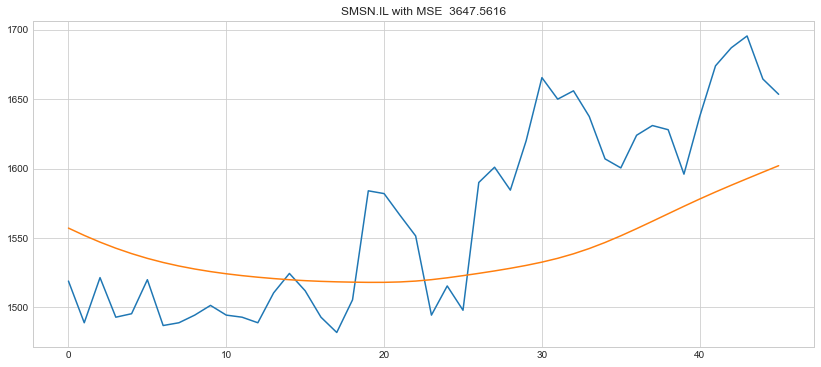

In [15]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [37]:
df_new["AAPL"]["Test"][60:].shape

(46,)

In [ ]:
def pred_graph(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    for i in stockList:
        time_index = df_new[i]["Test"][60:].index
        df_pred = pd.Series(pred_result[i]["Pred"].reshape(-1), index=time_index)
        df_true = pd.Series(pred_result[i]["True"].reshape(-1), index=time_index)
        mse = mean_squared_error(np.array(df_true), np.array(df_pred))
        fig = make_subplots()
        fig.add_trace(go.Scatter(x=time_index, y=df_pred, name="Prediction"))
        fig.add_trace(go.Scatter(x=time_index, y=df_true, name="Actual data"))
        # Add figure title
        fig.update_layout(
            title={
                    'text': f'{i} Closing Price Prediction with MSE: {mse}',
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'
                },
        )

        # Set x-axis title
        fig.update_xaxes(title_text="Date")
        # Set y-axes titles
        fig.update_yaxes(title_text="Closing Price")
        fig.show()

In [16]:
time_index = df_new["AAPL"]["Test"][60:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.plot(df_true)
    plt.plot(df_pred_lag)

MSE without Lag 113.59010384595351
MSE with Lag 5 62.28189028160458


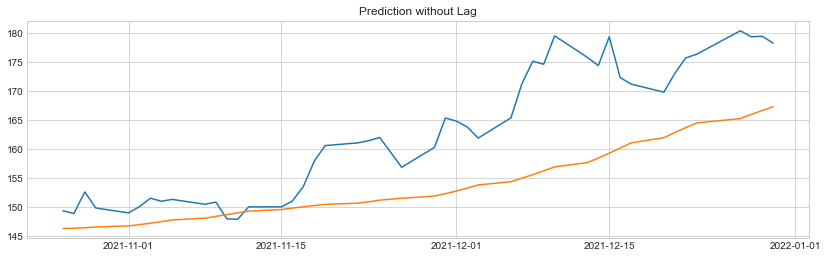

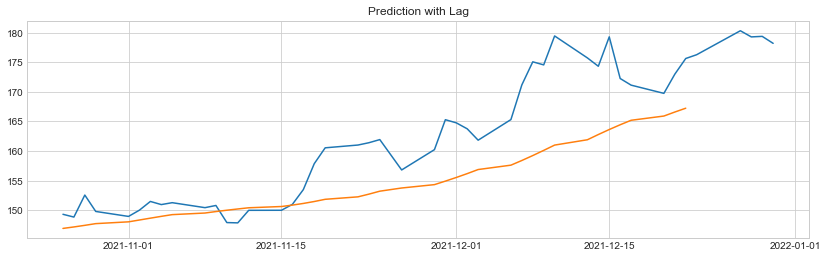

In [17]:
lagging(pred_result["AAPL"], -5, time_index)

In [23]:
pred_result["SMSN.IL"]['Pred'].reshape(-1).shape

(46,)

MSE without Lag 3647.561560938863
MSE with Lag 5 1992.8450459052874


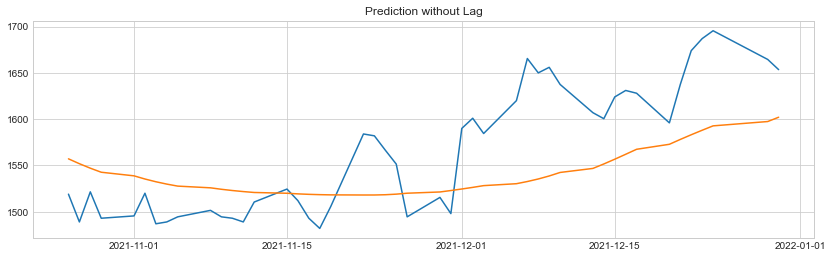

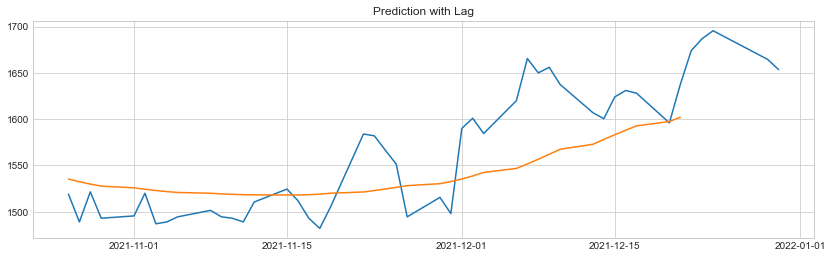

In [18]:
time_index = df_new["SMSN.IL"]["Test"][60:].index
lagging(pred_result["SMSN.IL"], -5, time_index)